## Feature selection using two-stage filtering method  
We applied a two-stage filtering feature selection method for both bow and tfi-df text representation only.    
filter 1 - remove feature with low variance
filter 2 - remove redundant features using MI score   
text_bow1_kt:  

| Using all features bow1:    | LR = 0.7389736477115117 | (6459 features) |
|-----------------------------|-------------------------|-----------------|
| With our two-stage FS bow1: | LR = 0.7147018030513176 | (1394 features) |

text_bow1_ws:  

| Using all features bow1:    | LR = 0.6877531941414771 | (6459 features) |
|-----------------------------|-------------------------|-----------------|
| With our two-stage FS bow1: | LR = 0.6678092863820505 | (588 features) |


pree.t@cmu.ac.th  

In [13]:
import joblib
import os
import numpy as np
from scipy import sparse
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif

import matplotlib.pyplot as plt

os.path.dirname(os.getcwd())

model_path = os.path.dirname(os.getcwd()) + '\\model\\'
lexicon_path = os.path.dirname(os.getcwd()) + '\\lexicon\\'

In [14]:
# preparing all data 

text_bow1_kt = joblib.load(model_path+'text_bow1_kt.pkl')
text_bow1_ws = joblib.load(model_path+'text_bow1_ws.pkl')

text_bow2_kt = joblib.load(model_path+'text_bow2_kt.pkl')
text_bow2_ws = joblib.load(model_path+'text_bow2_ws.pkl')

text_tfidf1_kt = joblib.load(model_path+'text_tfidf1_kt.pkl')
text_tfidf1_ws = joblib.load(model_path+'text_tfidf1_ws.pkl')

text_tfidf2_kt = joblib.load(model_path+'text_tfidf2_kt.pkl')
text_tfidf2_ws = joblib.load(model_path+'text_tfidf2_ws.pkl')

all_texts = [["text_bow1_kt", text_bow1_kt],
               ["text_bow1_ws", text_bow1_ws],
            #  ["text_bow2_kt", text_bow2_kt],
            #  ["text_bow2_ws", text_bow2_ws],
            #  ["text_tfidf1_kt", text_tfidf1_kt],
            #  ["text_tfidf1_ws", text_tfidf1_ws],
            #  ["text_tfidf2_kt", text_tfidf2_kt],
            #  ["text_tfidf2_ws", text_tfidf2_ws]
            ]
# lex_bow1_kt = joblib.load(lexicon_path+'lex_bow1_kt.pkl')
# lex_bow1_ws = joblib.load(lexicon_path+'lex_bow1_ws.pkl')

# lex_bow2_kt = joblib.load(lexicon_path+'lex_bow2_kt.pkl')
# lex_bow2_ws = joblib.load(lexicon_path+'lex_bow2_ws.pkl')

In [15]:
def plot_feature_scores(threshold_val):
    fig = plt.figure(figsize=(9, 7), dpi=80) 
    ax = plt.axes()
    ax.axhline(threshold_val, ls='dotted', c='r')
    ax.plot(vt.variances_)
    return

## Select using fix dim

In [16]:

'''
parem:  X = features, y= target
        vt_dim = dimension for first filter,
        mi_dim = diminsion last filter
return: array 
'''
def twosteps_fs(X, y, vt_dim, mi_dim):
        vt = VarianceThreshold()
        vt.fit(X)
        feature_scores = vt.variances_

        idx = np.flip(np.argsort(feature_scores))
        tmp = np.take(X, idx.flatten(), axis=1)        
        X_vt = tmp[:, :vt_dim]

        feature_scores = mutual_info_classif(X_vt, np.ravel(y), random_state=0)
        mi_idx = np.flip(np.argsort(feature_scores))
        tmp = np.take(X_vt, mi_idx.flatten(), axis=1)        
        X_vt_mi = tmp[:, :mi_dim]
        return X_vt_mi

In [17]:
%%time
vt_dim = 1500
mi_dim = 700
for i in range(len(all_texts)):
    X, y = all_texts[i][1]
    X = X.A
    y = y.A
    X_vt_mi = twosteps_fs(X, y, vt_dim, mi_dim)

    arr = np.hstack((sparse.csr_matrix(X_vt_mi), sparse.csr_matrix(y)))
    joblib.dump(arr, model_path + all_texts[i][0] + "_fs.pkl")

## Manually select using specfic thresholds

In [24]:
# select using manual threshold
X, y = text_bow1_kt
X = X.A
y = y.A

print(X.shape)
print(y.shape)

(60081, 6459)
(60081, 1)


## Filter 1 - remove features with low variance

In [25]:
# bow1_kt 0.00035
# bow1_ws 0.003
# bow2_kt 0.00065
# bow2_ws
# tfidf1_kt
# tfidf1_ws
# tfidf2_kt
# tfidf2_ws
threshold_val = 0.00035
vt = VarianceThreshold(threshold=threshold_val)
vt.fit(X)
mask = vt.get_support()

In [26]:
idx = np.where(mask==False)
print("total number of feature will be removed:", len(idx[0]))
X_vt =  np.delete(X, idx, 1)
X_vt.shape

total number of feature will be removed: 3755


(60081, 2704)

## Filter 2 remove using MI score

In [27]:
#calcuate mi score of the remaining terms
feature_scores = mutual_info_classif(X_vt, np.ravel(y), random_state=0)

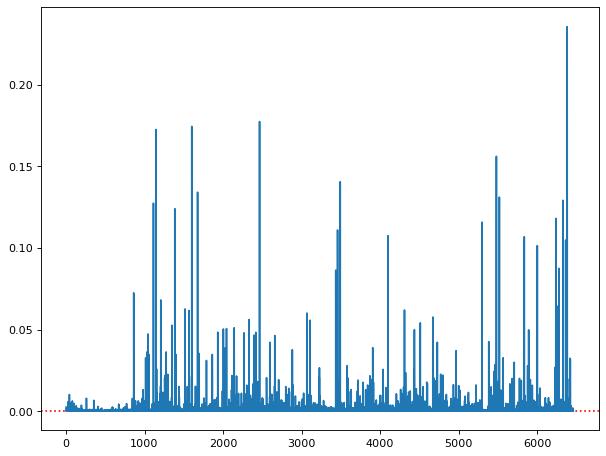

In [28]:
# bow1_kt = 0.0001
# bow1_ws = 0.0005
mi_threshold_val = 0.0001
plot_feature_scores(mi_threshold_val)

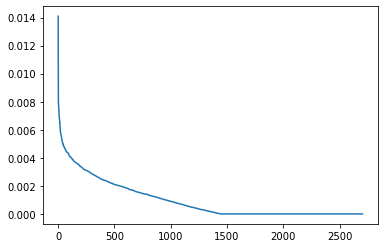

In [29]:
# set another mi score threshold manually, so that we can have reasonable size
plt.plot(-np.sort(-feature_scores))

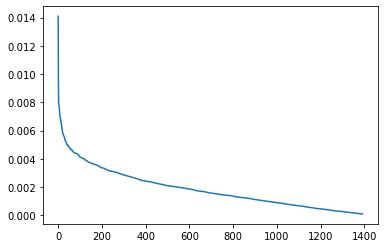

In [30]:
feature_scores_final = feature_scores[feature_scores > mi_threshold_val]
plt.plot(-np.sort(-feature_scores_final))

In [31]:
# select with threshold
mi_idx = np.argwhere(feature_scores > mi_threshold_val)
X_vt_mi = np.take(X_vt, mi_idx.flatten(), axis=1)
X_vt_mi.shape

(60081, 1393)

In [32]:
arr_new = np.hstack((sparse.csr_matrix(X_vt_mi), sparse.csr_matrix(y)))
joblib.dump(arr_new, model_path+'text_bow1_ws_kt.pkl')

['c:\\Users\\Pree\\Thai_SA_journal\\model\\text_bow1_ws_kt.pkl']

## Test with LR

In [19]:
item = joblib.load(model_path+'text_bow1_kt_fs.pkl')

arr_kt = np.concatenate((item[0].A, item[1].A), axis=1)

In [20]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression

In [21]:
train_df, test_df = train_test_split(arr_kt, test_size=0.20, random_state=42)
train_df.shape, test_df.shape

((48064, 701), (12017, 701))

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df[:,:-1], train_df[:,-1], test_size=0.15, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((40854, 700), (7210, 700), (40854,), (7210,))

In [23]:
model = LogisticRegression(C=2., penalty="l2", solver="liblinear", dual=False, multi_class="ovr")
model.fit(X_train, y_train)
round(model.score(X_valid, y_valid), 4)

0.7123